In [7]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

In [8]:
T = BigFloat

BigFloat

In [9]:
beta::Float64 = 100
wmax::Float64 = 10
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 10.0

In [10]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [11]:
nsize::Int64 = 1024
eta::Float64 = 0.01
t_pra::Float64 = 0.0
filling::Float64 = 1.0
U::Float64 = 0.5
hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [12]:
function exact_suscep(qx, qy, omega, eta, nsize, beta, hami)
    chi::ComplexF64 = 0
    for ix in 1:nsize, iy in 1:nsize
        kx::Float64 = 2*π*(ix-1)/nsize
        ky::Float64 = 2*π*(iy-1)/nsize
        ek  = hami(kx,ky)
        ekq = hami(kx-qx,ky-qy)
        chi += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega+im*eta+ekq-ek)
    end
    chi = chi/(nsize*nsize)
    return chi
end

exact_suscep (generic function with 1 method)

In [13]:
rho(omega) = imag(exact_suscep(π,π,omega, eta, nsize, SparseIR.β(basis),hami))/(pi*tanh(0.5*SparseIR.β(basis)*omega))

rho (generic function with 1 method)

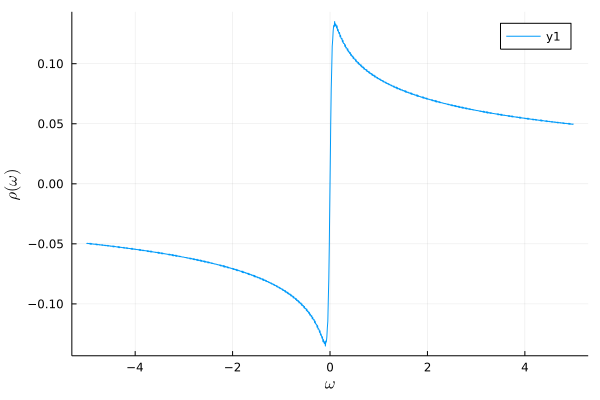

In [14]:
omegas = LinRange(-5, 5, 1000)
plot(omegas, rho.(omegas).*tanh.(0.5*beta*omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [ ]:
rhol = [overlap(basis.basis_b.v[l], rho) for l in 1:length(basis.basis_b)]
chil = - basis.basis_b.s .* rhol

In [16]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chil),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

LoadError: SYSTEM: show(lasterr) caused an error

In [17]:
chiw = evaluate(basis.smpl_wn_f, chil)
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

LoadError: UndefVarError: chil not defined

In [18]:
plot(title="chisw_fermi")
plot!(real.(chiw[:]), label="real")
plot!(imag.(chiw[:]), label="imag")

LoadError: InterruptException:

In [19]:
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chil) + dot(basis.basis_f.u(0), chil))

LoadError: UndefVarError: chil not defined

In [20]:
setprecision(512)

LoadError: InterruptException:

In [21]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

LoadError: UndefVarError: hnw not defined

In [22]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    input_chi[i]  = -chiw[hnw+i]
end

LoadError: UndefVarError: hnw not defined

In [23]:
N_real    =  6000
omega_max =  10.0
#eta       =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
#N_imag = hnw 
println("N_imag $(N_imag)")

LoadError: UndefVarError: hnw not defined

In [24]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [38]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, input_smpl, input_chi, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     5.049259e+02     7.006271e+01
 * time: 0.015557050704956055
     1     4.104250e+02     4.108822e+01
 * time: 9.537883996963501
     2     4.066656e+02     4.505710e+01
 * time: 12.225700855255127
     3     4.037888e+02     1.853471e+01
 * time: 14.287835836410522
     4     4.034795e+02     7.768617e+00
 * time: 15.644892930984497
     5     4.033076e+02     2.107659e+00
 * time: 17.005944967269897
     6     4.032537e+02     7.094049e-01
 * time: 19.068285942077637
     7     4.032491e+02     7.177273e-01
 * time: 20.397003889083862
     8     4.032475e+02     1.938747e-01
 * time: 22.457778930664062
     9     4.032473e+02     8.072725e-02
 * time: 24.50060796737671
    10     4.032472e+02     4.081252e-02
 * time: 25.88780403137207
    11     4.032472e+02     2.917327e-02
 * time: 27.97202706336975
    12     4.032472e+02     8.519209e-03
 * time: 29.340378999710083
    13     4.032472e+

In [39]:
@time Nevanlinna.solve!(sol)
;

H=1
Iter     Function value   Gradient norm 
     0     4.032472e+02     7.187607e-09
 * time: 0.0001881122589111328
max_theta=0.901869697291441715022527765239448630505496368447431350209606202002053368666949824307614081983015618217199865504601268056545516039861742093250990837328018877
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.032472e+02     4.343475e+01
 * time: 0.00019097328186035156
     1     3.991923e+02     7.928899e+01
 * time: 2.948042154312134
     2     3.867019e+02     6.981013e+01
 * time: 5.806166172027588
     3     3.781290e+02     6.089793e+01
 * time: 9.31929898262024
     4     3.747387e+02     4.469245e+01
 * time: 12.129372119903564
     5     3.724903e+02     2.776131e+01
 * time: 14.815906047821045
     6     3.716673e+02     2.547257e+01
 * time: 16.19909906387329
     7     3.702026e+02     4.650147e+00
 * time: 18.27723717689514
     8     3.700361e+02     2.219346e+00
 * time: 19.66999912261963
     9     3.699220

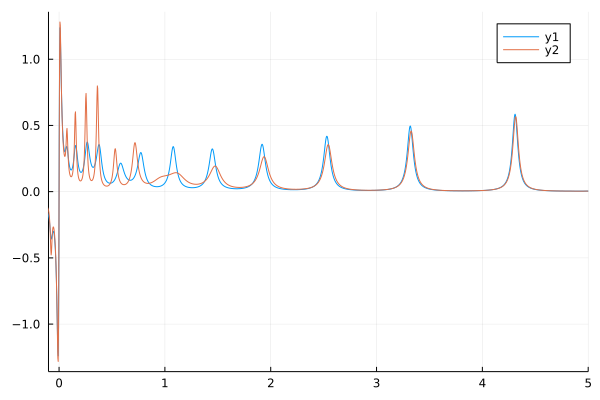

In [40]:
plot(xlim = [-0.1,5])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(sol.reals.freq), imag.(sol.reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))

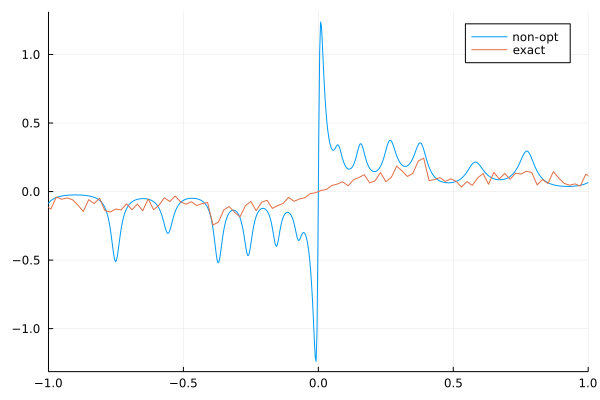

In [36]:
plot(xlim = [-1,1])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt", marker=:+)
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

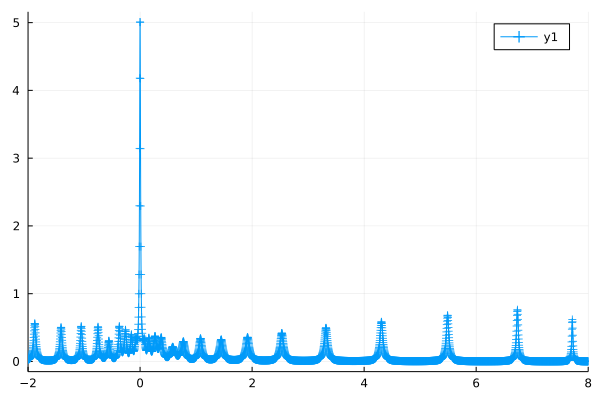

In [37]:
plot(xlim = [-2,8])
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/pi)))

In [34]:
ComplexF64.(raw_reals.freq[1])

-10.0 + 0.01im